In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import tslearn
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
import numpy as np
from config import *
result_directory = result_parent_directory + os.sep + 'step2_k_means_clustering'
os.makedirs(result_directory, exist_ok=True)


c:\Users\akaju\anaconda3\envs\py_btms_controller\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


## load data

In [2]:
# import all charging power predictions from directory
df_loaded_list = []
for file in os.listdir(prediction_directory):
    if file.endswith(".csv"):
        _df_loaded = pd.read_csv(prediction_directory+ os.sep + file, index_col = 0)
        # append one column to the dataframe
        df_loaded_list.append(_df_loaded)

# get a list of taz number of each charging station
taz_list = []
for file in os.listdir(prediction_directory):
    if file.endswith(".csv"):
        taz_list.append(int(file.split(".")[0]))

In [3]:
# construct numpy array from the list of dataframes
def construct_numpy_array(df_list, choose_column):
    # construct numpy array
    array = np.zeros((len(df_list), len(df_list[0]))) # vector of shape (number of charging stations, number of time steps)
    timevector = df_list[0]["time"].to_numpy()
    for i in range(len(df_list)):
        array[i] = df_list[i][choose_column]
    return array, timevector

charging_trajectories_loaded, timevector_loaded = construct_numpy_array(df_loaded_list, "Power_original")

#### plot all predictions

In [65]:
charging_trajectories_loaded

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

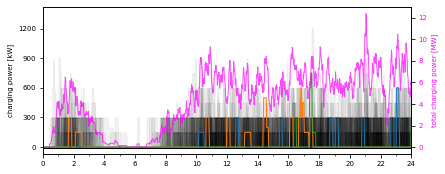

In [78]:
# plot all charging power predictions in one figure
%matplotlib inline
plt.figure()
pltSettings()
for i in range(charging_trajectories_loaded.shape[0]):
    # plot trajectories by filling area between 0 and the trajectory
    plt.fill_between(timevector_loaded/3600, charging_trajectories_loaded[i], color= 'black', alpha = 0.05, rasterized = True)
# plot some examples
plot_index = [20, 100, 58]
for i in range(len(plot_index)):
    plt.plot(timevector_loaded/3600, charging_trajectories_loaded[plot_index[i]], linewidth = 1)
ax = plt.gca()
# add second y axis
ax2 = plt.twinx()
ax2.set_ylabel("cumulated charging power [kW]")
ax2.plot(timevector_loaded/3600, np.sum(charging_trajectories_loaded, axis = 0)/1000, color = 'magenta', linewidth = 1, alpha = 0.7)
ax2.set_ylabel("total charging power [MW]", color = 'magenta')
ax2.tick_params(axis='y', labelcolor='magenta')
plt.xlabel("time [h]")
ax.set_ylabel("charging power [kW]")
ax.set_xlim([0,24])
ax.set_xticks(np.arange(0,25,2))
# set minor ticks inbetween
ax.set_xticks(np.arange(0,25,1), minor = True)
ax.set_yticks(np.arange(0, charging_trajectories_loaded.max(), 300))
fig = plt.gcf()
fig.set_size_inches(plotSizeX2col, plotSizeY2col) #6.6, 2.7)

# save figure as pdf
# reduce figure size
fig.savefig(result_directory + os.sep + "chargingPowerPredictions.pdf", bbox_inches='tight', )

## k means clustering

integrate charged power to get energy trajectories for clustering

In [47]:
timestep_new_in_min = 1

timestep_new_in_sec = timestep_new_in_min*60
timevector_new = np.arange(1, 24*3600, timestep_new_in_sec)
charging_trajectories_integrated = np.zeros((charging_trajectories_loaded.shape[0], len(timevector_new)))
for i in range(charging_trajectories_loaded.shape[0]):
    j0 = 0
    for j in range(1, len(timevector_new)):
        charging_trajectories_integrated[i,j] = charging_trajectories_integrated[i,j-1] + sum(charging_trajectories_loaded[i, j0:j0+timestep_new_in_min]*timestep/3.6e3) # to calculate energy, multiply with timestep/3.6e3 in kWh
        j0 = j0 + timestep_new_in_min

normalize charging stations by their total charged energy for better clustering

In [48]:
normalize = True

if normalize:
    for i in range(0, charging_trajectories_integrated.shape[0]):
        if charging_trajectories_integrated[i].max() != 0:
            charging_trajectories_integrated[i] = charging_trajectories_integrated[i]/charging_trajectories_integrated[i].max()

# remove all charging power predictions that are zero
idx = charging_trajectories_integrated[:,-1] != 0
idx_inv = charging_trajectories_integrated[:,-1] == 0
# print removed taz and save them in a list
taz_removed = np.array(taz_list)[idx_inv]
print('number of removed taz: ' + str(sum(idx_inv)))
print('removed taz: ' + str(taz_removed))
# remove zero trajectories
charging_trajectories_integrated = charging_trajectories_integrated[idx]
taz_list_without_zeros = np.array(taz_list)[idx]

number of removed taz: 2
removed taz: [   0 1028]


plot normalized charging energy trajectories in one figure

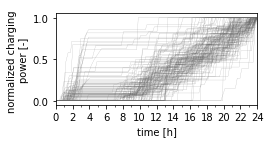

In [49]:
# plot all charging power predictions in one figure
plt.figure()
pltSettings()
%matplotlib inline
# set the color of the lines
colors = plt.cm.jet(np.linspace(0,1,charging_trajectories_integrated.shape[0]))
for i in range(charging_trajectories_integrated.shape[0]):
    plt.plot(timevector_new/3600, charging_trajectories_integrated[i], color = 'dimgrey', alpha = 0.6, linewidth = 0.2)
plt.xlabel("time [h]")
plt.ylabel("normalized charging \npower [-]")
#plt.title("Charging power predictions")
ax = plt.gca()
ax.set_xlim([0,24])
ax.set_xticks(np.arange(0,25,2))
# set minor ticks inbetween
ax.set_xticks(np.arange(0,25,1), minor = True)
#ax.set_yticks(np.arange(0, array_new.max(), 300))
fig = plt.gcf()
fig.set_size_inches(plotSizeX, 1.4* plotSizeY) #6.6, 2.7)

# save figure as pdf
fig.savefig(result_directory + os.sep + "chargingPowerPredictions.pdf", bbox_inches='tight')

perform k-means clustering on normalized charging energy trajectories with euclidean distance

In [50]:
import tqdm
n_clusters_list = np.arange(2, 10, 1)
k_means_list = []
cluster_found_list=[]
silhouette_scores = []

X = charging_trajectories_integrated.reshape(charging_trajectories_integrated.shape[0], charging_trajectories_integrated.shape[1], 1)

for n_clusters in tqdm.tqdm(n_clusters_list):
    #k_means = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw_", verbose=True, n_jobs = -1)
    k_means = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", verbose=False, n_jobs = -1)
    cluster_found = k_means.fit_predict(X)
    
    cluster_found_list.append(cluster_found)
    silhouette_scores.append(k_means.inertia_)
    k_means_list.append(k_means)

100%|██████████| 8/8 [00:01<00:00,  6.57it/s]


plot silhouette score for different number of clusters "ellbow method"

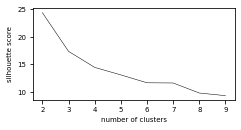

In [51]:
%matplotlib inline
plt.figure
pltSettings()
plt.plot(n_clusters_list, silhouette_scores, color = 'black', linewidth = 0.5)
plt.xlabel("number of clusters")
plt.ylabel("silhouette score")
fig = plt.gcf()
fig.set_size_inches(plotSizeX, 1.4*plotSizeY)

# save figure as pdf
fig.savefig(result_directory + os.sep + "silhouetteScore.pdf", bbox_inches='tight')

plot clusters and their centroids

In [61]:
%matplotlib qt
n_clusters = 3

n_clusters_real = n_clusters-n_clusters_list[0]
k_means = k_means_list[n_clusters_real]
cluster_found = cluster_found_list[n_clusters_real]
cluster_found = pd.Series(cluster_found, name = "cluster")

fig, ax = plt. subplots(1,n_clusters, sharey = True, sharex=True)
pltSettings()
#color_list = plt.cm.hsv(np.linspace(0,1,n_clusters))

def get_tunnel(dba_km_cluster_center, plus):    
    dba_reshaped = dba_km_cluster_center.reshape((1,-1))
    if plus:
        concat = np.concatenate((dba_reshaped + 0.1, np.ones_like(dba_reshaped)), axis = 0)
        dba_tunnel = np.min(concat, axis = 0)  
    else:
        concat = np.concatenate((dba_reshaped - 0.1, np.zeros_like(dba_reshaped)), axis = 0)
        dba_tunnel= np.max(concat, axis = 0)  
    return dba_tunnel

for i in range(n_clusters):
    cluster = cluster_found[cluster_found == i]
    for j in cluster.index:
        ax[i].step(timevector_new/3600, X[j], color = 'black', alpha = 0.15, linewidth = 0.5)
    ax[i].plot(timevector_new/3600, k_means.cluster_centers_[i].ravel(), color = 'black', linewidth = 2)
    # plot line 20% above and below median
    #ax[i].fill_between(timevector_new/3600, get_tunnel(k_means.cluster_centers_[i].ravel(), True), get_tunnel(k_means.cluster_centers_[i].ravel(), False), color = color_list[i], alpha = 0.2)
    # add title
    ax[i].title.set_text('cluster ' + str(i+1))
    ax[i].set_xlim([0,24])
    ax[i].set_xticks(np.arange(0,25,6))
    ax[i].set_ylim([0,1])
    ax[i].set_yticks(np.arange(0,1.1,0.5))
    ax[i].set_xlabel("time [h]")
    ax[i].set_box_aspect(1)#aspect(1./ax[i].get_data_ratio(), adjustable='box')
ax[0].set_ylabel("normalized \ncharging power [-]")
#plt.rcParams.update({'font.size': 7})
# make plots quadratic

fig.set_size_inches(plotSizeX, 2*plotSizeY) # y size is automatically reduced when saving with bbox_inches='tight'
fig.savefig(result_directory + os.sep + "clusteredChargingPowerPredictions.pdf", bbox_inches='tight')

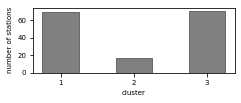

In [54]:
# plot histogram of cluster sizes
%matplotlib inline
plt.figure()
pltSettings()
plt.hist(cluster_found, bins = np.arange(0, n_clusters+1, 1), color = 'grey', edgecolor = 'dimgrey', rwidth=0.5, align='right')
plt.xlabel("cluster")
plt.xticks(np.arange(1, n_clusters+1, 1))
plt.ylabel("number of stations")

fig = plt.gcf()
fig.set_size_inches(plotSizeX, plotSizeY) # y size is automatically reduced when saving with bbox_inches='tight'
fig.savefig(result_directory + os.sep + "number_of_trajectories_per_cluster_Histogram.pdf", bbox_inches='tight')


In [55]:
# make a dataframe with number of stations per cluster
cluster_found_df = pd.DataFrame(cluster_found)
cluster_found_df['count'] = 1
cluster_found_df = cluster_found_df.groupby('cluster').count()
cluster_found_df = cluster_found_df.rename(columns = {'count': 'number of stations'})
cluster_found_df.index = cluster_found_df.index + 1
# change columns and rows
cluster_found_array = cluster_found_df.to_numpy()
cluster_found_array = cluster_found_array.reshape((1,-1))
cluster_found_array = cluster_found_array[0]
cluster_found_df = pd.DataFrame(cluster_found_array)
cluster_found_df = cluster_found_df.transpose()
cluster_found_df.columns = np.arange(1, n_clusters+1, 1)
cluster_found_df.index = ['number of stations']
cluster_found_df.columns.name = 'cluster'

# export as latex table
cluster_found_df.to_latex(result_directory + os.sep + "number_of_trajectories_per_cluster.tex")
cluster_found_df

cluster,1,2,3
number of stations,69,17,71


## save results

In [56]:
taz_series = pd.Series(taz_list_without_zeros, name = "taz")

df_taz_with_cluster = pd.concat([taz_series, cluster_found], axis = 1)
df_taz_with_cluster.set_index("taz", inplace = True)

df_taz_with_cluster.to_csv(result_directory + os.sep + "taz_with_cluster.csv")

## save infrastructure file with removed charging stations

In [57]:
# load the infrastructure file
df_infrastructure = pd.read_csv(path_infrastructure, index_col= "taz")
df_infrastructure_removed_zeros = df_infrastructure.loc[taz_list_without_zeros]
# save the infrastructure file
df_infrastructure_removed_zeros.to_csv(result_directory + os.sep + "infrastructure_removed_zeros.csv")

In [58]:
# make table histogram
# remove stations with no charging power
df_infrastructure_removed_zeros = df_infrastructure.loc[taz_list_without_zeros]
print('number of depots: ' + str(len(df_infrastructure_removed_zeros)))
num_stalls = df_infrastructure_removed_zeros['numStalls']
plug_range = np.sort(num_stalls.unique())

# plot histogram of cluster per histogram for each number of plugs
cluster_dist_over_plugs = np.zeros((len(plug_range), n_clusters))
for i in range(len(plug_range)):
    idx = df_infrastructure_removed_zeros['numStalls'] == plug_range[i]
    cluster_dist_over_plugs[i,:] = np.histogram(df_taz_with_cluster.loc[idx], bins = np.arange(0, n_clusters+1, 1))[0]

cluster_dist_over_plugs_df = pd.DataFrame(cluster_dist_over_plugs, dtype=int)
cluster_dist_over_plugs_df.columns = np.arange(1, n_clusters+1, 1)
cluster_dist_over_plugs_df.index = plug_range
cluster_dist_over_plugs_df.index.name = 'plugs'
cluster_dist_over_plugs_df.columns.name = 'cluster'
cluster_dist_over_plugs = cluster_dist_over_plugs_df.transpose()
cluster_dist_over_plugs.to_latex(result_directory + os.sep + "cluster_distribution_over_plugs.tex")
cluster_dist_over_plugs


number of depots: 157


plugs of station,1,2,3,4,5,6,7,8,9,10
cluster,,,,,,,,,,
1,12,15,11,14,8,4,3,0,1,1
2,7,5,3,0,0,2,0,0,0,0
3,7,12,14,17,12,5,2,1,0,1
